<a href="https://colab.research.google.com/github/mafervg/NFL-Predictions-and-betting-models/blob/main/NFL_model_prediction_sacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nfl_data_py
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
!pip install scikit-learn
!pip install xgboost

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=b5ec8996a21ff59a27bd47c0299c89c6a522ccfa7e703374b1ae0bcdcd49ed20
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

In [ ]:
pbp = nfl.import_pbp_data([2020, 2021, 2022])

2020 done.
2021 done.
2022 done.
Downcasting floats.


In [ ]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,None,None,None,...,None,None,NaN,None,NaN,,,,0.0,0.0
1,39.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,None,None,NaN,None,NaN,45142;46331;46674;45037;46253;44878;42579;4637...,00-0033258;00-0034490;00-0033862;00-0029747;00...,00-0034073;00-0034730;00-0033783;00-0031961;00...,11.0,11.0
2,54.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",4.0,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0
3,93.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",NaN,40078;46078;45069;46113;38551;45185;42718;4781...,00-0029892;00-0034847;00-0033221;00-0034860;00...,00-0029585;00-0035236;00-0031557;00-0035705;00...,11.0,11.0
4,118.0,2020_01_ARI_SF,2020091311,SF,ARI,REG,1,SF,home,ARI,...,SINGLEBACK,"2 RB, 1 TE, 2 WR",7.0,"2 DL, 5 LB, 4 DB",NaN,40078;46078;46113;45069;38551;45185;42718;4781...,00-0029892;00-0034847;00-0034860;00-0033221;00...,00-0029585;00-0035236;00-0031557;00-0029747;00...,11.0,11.0


PREDICT THE CHANCE OF A SACK ON A PLAY

Remove all the plays that are not relevant for out prediction.

In [ ]:
print(pbp.shape)
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != 'no_play')]
print(pbp_clean.shape)

(149373, 384)
(64411, 384)


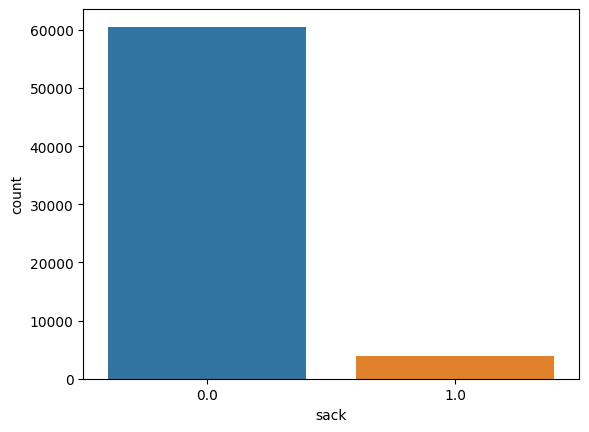

In [ ]:
sns.countplot(x = pbp_clean['sack'])
plt.show()

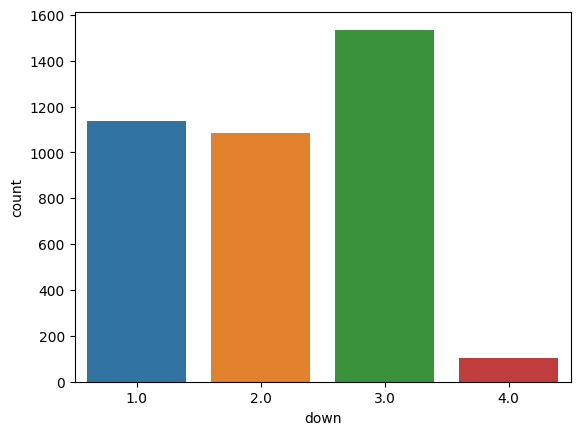

In [ ]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks['down'])
plt.show()

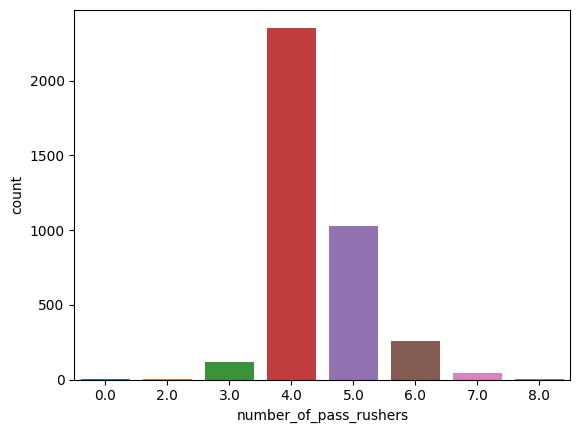

In [ ]:
sns.countplot(x=sacks['number_of_pass_rushers'])
plt.show()

In [ ]:
pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >=6), 1, 0)

<ipython-input-9-f7a4399f0300>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_clean['obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >=6), 1, 0)


In [ ]:
pre_df = pbp_clean[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
                    'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
pre_df.isna().sum()

game_id                      0
play_id                      0
season                       0
name                         7
down                       307
ydstogo                      0
yardline_100                 0
game_seconds_remaining       0
defenders_in_box           678
number_of_pass_rushers    1043
xpass                      307
obvious_pass                 0
sack                         0
dtype: int64

In [ ]:
df = pre_df.dropna()
df.isna().sum()

game_id                   0
play_id                   0
season                    0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
xpass                     0
obvious_pass              0
sack                      0
dtype: int64

In [ ]:
print(df.shape)
df.head()

(63333, 13)


,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
2,2020_01_ARI_SF,54.0,2020,J.Garoppolo,1.0,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0
6,2020_01_ARI_SF,165.0,2020,J.Garoppolo,3.0,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0
9,2020_01_ARI_SF,245.0,2020,K.Murray,1.0,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0
10,2020_01_ARI_SF,274.0,2020,K.Murray,2.0,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0
11,2020_01_ARI_SF,298.0,2020,K.Murray,1.0,10.0,65.0,3360.0,6.0,5.0,0.453060,0,0.0


In [ ]:
df['down'] = df['down'].astype('category')
df_no_ids = df.drop(columns= ['game_id', 'play_id', 'name', 'season'])
df_no_ids = pd.get_dummies(df_no_ids, columns = ['down'])

<ipython-input-13-eae2ba004f35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['down'] = df['down'].astype('category')


In [ ]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [ ]:
df_no_ids.head()

,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack,down_1.0,down_2.0,down_3.0,down_4.0
2,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0,1,0,0,0
6,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0,0,0,1,0
9,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0,1,0,0,0
10,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0,0,1,0,0
11,10.0,65.0,3360.0,6.0,5.0,0.453060,0,0.0,1,0,0,0


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
  strat_train_set = df_no_ids.iloc[train_index]
  strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns=['sack'])
y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns =['sack'])
y_test = strat_test_set['sack']


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_pred = pd.DataFrame(lr.predict_proba(X_test), columns=['no_sack', 'sack'])
lr_pred

,no_sack,sack
0,0.907289,0.092711
1,0.936876,0.063124
2,0.902671,0.097329
3,0.927428,0.072572
4,0.956667,0.043333
...,...,...
15829,0.930389,0.069611
15830,0.950160,0.049840
15831,0.949816,0.050184
15832,0.935626,0.064374


In [ ]:
lr_pred = pd.DataFrame(lr.predict_proba(X_test), columns=['no_sack', 'sack'])[['sack']]
print('Brier Score: ', brier_score_loss(y_test, lr_pred))

Brier Score:  0.056650718844646


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_pred = pd.DataFrame(rf.predict_proba(X_test), columns=['no_sack', 'sack'])[['sack']]
print('Brier Score: ', brier_score_loss(y_test, rf_pred))

Brier Score:  0.059614832284254696


In [ ]:
xgb = XGBClassifier(objective="binary:logistic", random_state=42)
xgb.fit(X_train, y_train)

xgb_pred = pd.DataFrame(xgb.predict_proba(X_test), columns=['no_sack', 'sack'])[['sack']]
print('Brier Score: ', brier_score_loss(y_test, xgb_pred))

Brier Score:  0.057292580631850415


In [ ]:
## TUNED XGBClassifier
# XGB = XGBClassifier(objective="binary:logistic", random_state=42)
# XGB.fit(X_train, Y_train)
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.01, 0.3), # default 0.1
#     "max_depth": randint(2, 8), # default 3
#     "n_estimators": randint(50, 200), # default 100
#     "subsample": uniform(0.6, 0.4)
# }
# search = RandomizedSearchCV(XGB, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=3, n_jobs=1, return_train_score=True)
# search.fit(X_train, Y_train)
# XGB_tuned = XGBClassifier(objective='binary:logistic',
#                           colsample_bytree = search.best_params_['colsample_bytree'],
#                           gamma = search.best_params_['gamma'],
#                           learning_rate = search.best_params_['learning_rate'],
#                           max_depth = search.best_params_['max_depth'],
#                           n_estimators = search.best_params_['n_estimators'],
#                           subsample = search.best_params_['subsample'],
#                          random_state = 42)
# XGB_tuned.fit(X_train, Y_train)
# XGB_tuned_pred = pd.DataFrame(XGB_tuned.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]
# print('Brier Score: ', brier_score_loss(Y_test, XGB_tuned_pred))


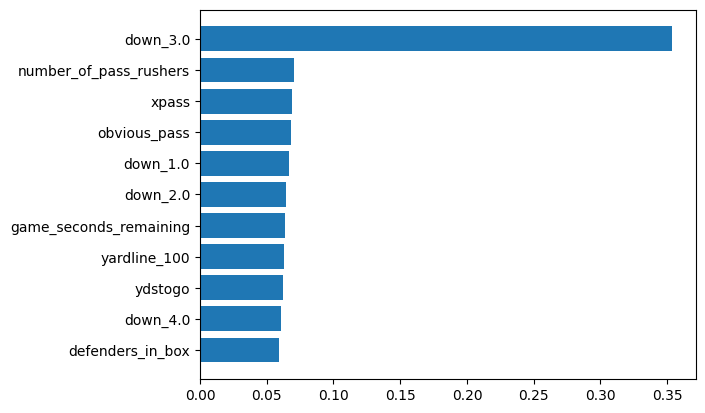

In [ ]:
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.show()

In [ ]:
make_sacks_preds = df_no_ids.drop('sack', axis = 1)
xgb_total_predictions = pd.DataFrame(xgb.predict_proba(make_sacks_preds), columns = ['no_sack', 'sack_pred'])[['sack_pred']]

xgb_total_predictions

,sack_pred
0,0.007104
1,0.097385
2,0.016466
3,0.019243
4,0.056306
...,...
63328,0.023386
63329,0.039913
63330,0.042811
63331,0.042773


In [ ]:
sacks_pred = df.reset_index().drop(columns=['index'])
sacks_pred['sack_pred'] = xgb_total_predictions
sacks_pred.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack,sack_pred
0,2020_01_ARI_SF,54.0,2020,J.Garoppolo,1.0,10.0,75.0,3600.0,7.0,4.0,0.515058,0,0.0,0.007104
1,2020_01_ARI_SF,165.0,2020,J.Garoppolo,3.0,14.0,45.0,3459.0,5.0,4.0,0.971992,1,0.0,0.097385
2,2020_01_ARI_SF,245.0,2020,K.Murray,1.0,10.0,75.0,3410.0,5.0,4.0,0.442755,0,0.0,0.016466
3,2020_01_ARI_SF,274.0,2020,K.Murray,2.0,7.0,72.0,3384.0,7.0,4.0,0.597824,0,0.0,0.019243
4,2020_01_ARI_SF,298.0,2020,K.Murray,1.0,10.0,65.0,3360.0,6.0,5.0,0.453060,0,0.0,0.056306


In [ ]:
sacks_pred['sacks_over_expected'] = sacks_pred['sack'] - sacks_pred['sack_pred']
sacks_pred[(sacks_pred['season'] == 2022)].groupby('name').agg({'sack':'sum', 'sack_pred': 'sum', 'sacks_over_expected': 'sum'}).reset_index().sort_values('sacks_over_expected', ascending=True)

,name,sack,sack_pred,sacks_over_expected
94,T.Brady,24.0,45.225456,-21.225458
51,J.Goff,23.0,37.770164,-14.770166
83,P.Mahomes,29.0,42.858383,-13.858383
100,T.Lawrence,31.0,42.611317,-11.611318
28,D.Carr,27.0,34.850704,-7.850704
...,...,...,...,...
32,D.Jones,52.0,41.887123,10.112878
73,M.Stafford,29.0,18.700701,10.299298
8,B.Mayfield,36.0,23.667006,12.332994
87,R.Wilson,55.0,36.744392,18.255608


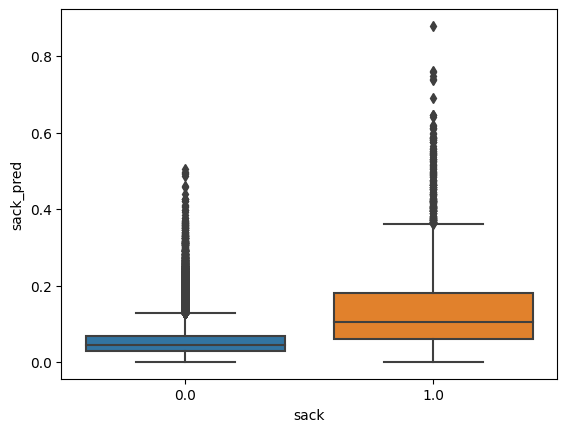

In [ ]:
sns.boxplot(x=sacks_pred['sack'], y=sacks_pred['sack_pred'])
plt.show()